In [1]:
import gymnasium as gym
from minigrid.wrappers import ImgObsWrapper
from my_wrapper import PotentialBasedRewardShaping, HierarchicalPotentialShaping

# 简单的动作映射
# MiniGrid 动作: 0:left, 1:right, 2:forward
ACTION_FORWARD = 2
ACTION_RIGHT = 1

def test_shaping_logic():
    print("--- 开始验证 Reward Shaping 逻辑 ---")
    
    # 1. 创建环境 (不带 ImgObsWrapper 以便我们能直接看内部状态，但在Wrapper内使用unwrapped)
    env = gym.make("MiniGrid-Empty-8x8-v0", render_mode=None)
    
    # 2. 加上我们的 Wrapper
    # 设置权重为 1.0 方便观察
    env = PotentialBasedRewardShaping(env, shaping_weight=1.0)
    
    env.reset()
    print(f"初始距离: {env.last_dist}")
    
    # 3. 强制让智能体向前走一步 (MiniGrid初始朝向通常是向右，目标在右下角)
    # 我们先转向直到面向目标的大致方向，然后前进
    # 在 Empty-8x8 中，Agent在(1,1)，朝向右(0)，Goal在(6,6)
    
    print("\n执行动作: 前进 (Forward) -> 应该靠近目标 -> 奖励应为正")
    obs, reward, term, trunc, info = env.step(ACTION_FORWARD)
    
    print(f"当前距离: {env.last_dist}")
    print(f"获得奖励: {reward:.4f}")
    print(f"Shaping部分: {info['shaping_reward']:.4f}")
    
    if info['shaping_reward'] > 0:
        print("✅ 测试通过：靠近目标获得了正向奖励！")
    elif info['shaping_reward'] < 0:
        print("❌ 测试失败：靠近目标却受到了惩罚？检查距离计算公式。")
    else:
        print("⚠️ 测试警告：奖励为0，可能没有移动或距离未变。")

    print("\n--- 验证结束 ---")

if __name__ == "__main__":
    test_shaping_logic()

--- 开始验证 Reward Shaping 逻辑 ---
初始距离: 10

执行动作: 前进 (Forward) -> 应该靠近目标 -> 奖励应为正
当前距离: 9
获得奖励: 1.0000
Shaping部分: 1.0000
✅ 测试通过：靠近目标获得了正向奖励！

--- 验证结束 ---


--- 验证开始：HierarchicalPotentialShaping ---
✅ 验证图表已保存为: verification_hierarchical_shaping.png

--- 关键势能事件 (Shaping Reward > 0.5) ---
     Step  Potential  Shaping_Reward  Has_Key  Door_Open
4       4        1.9           0.981     True      False
181   181        1.8           0.882     True      False
281   281        1.7           0.783     True      False
289   289        1.9           0.981     True      False
300   300        2.6           0.674     True       True
522   522        1.9           0.981     True      False
570   570        1.9           0.981     True      False
582   582        1.9           0.981     True      False
636   636        1.8           0.882     True      False
739   739        1.8           0.882     True      False
757   757        2.6           0.674     True       True
774   774        2.6           0.674     True       True
789   789        2.6           0.674     True       True
903   903        1.8           0.882     True      False
908   908     

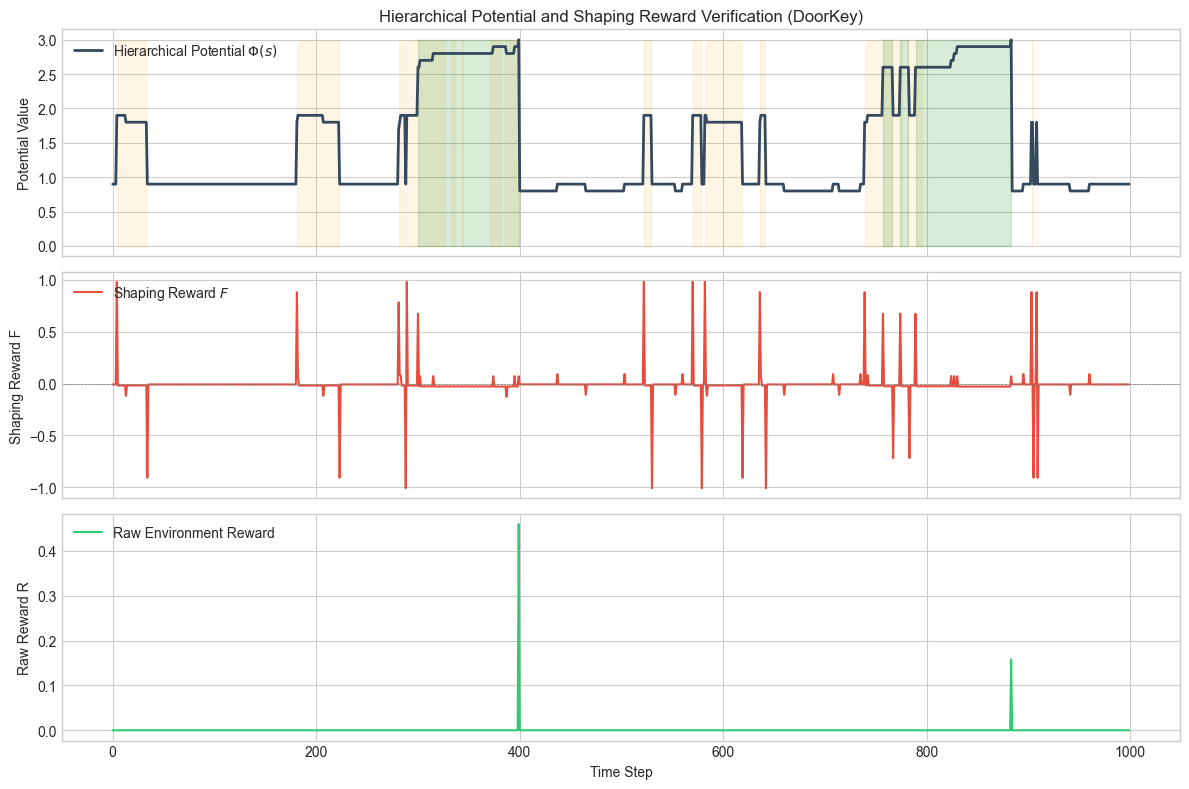

In [4]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minigrid.core.world_object import Key, Door, Goal

# 假设你的 HierarchicalPotentialShaping 定义在这里，或者已经 import
# from your_module import HierarchicalPotentialShaping

def test_potential_shaping_correctness(wrapper_class, total_steps=1000):
    """
    测试给定的 Wrapper 类在 DoorKey 上的势能变化 (修复版)
    """
    ENV_ID = "MiniGrid-DoorKey-5x5-v0"
    
    # 1. 初始化环境
    env = gym.make(ENV_ID, render_mode="rgb_array")
    env = ImgObsWrapper(env)
    
    # 2. 应用 Wrapper
    # 强制设置 weight=1.0 以便方便计算验证
    shaping_env = wrapper_class(env, shaping_weight=1.0)
    
    # 记录数据
    test_log = {
        'Step': [],
        'Raw_Reward': [],        
        'Potential': [],         
        'Shaping_Reward': [],    
        'Total_Reward': [],      
        'Has_Key': [],           
        'Door_Open': [],         
    }

    # 重置环境，这会初始化 shaping_env.last_potential
    obs, info = shaping_env.reset(seed=42)
    
    print(f"--- 验证开始：{wrapper_class.__name__} ---")
    
    # 获取 gamma (假设 wrapper 中定义了 self.gamma，通常是 0.99)
    gamma = getattr(shaping_env, 'gamma', 0.99) 

    for t in range(total_steps):
        # A. 记录 step 之前的势能 Phi(s)
        # 在 step 调用前，last_potential 存储的就是当前的势能
        phi_s = shaping_env.last_potential
        
        # B. 采取行动
        action = shaping_env.action_space.sample() 
        obs, total_reward, terminated, truncated, info = shaping_env.step(action)
        
        # C. 获取 step 之后的势能 Phi(s')
        # step 执行后，last_potential 已经被 wrapper 更新为当前的势能了
        phi_s_prime = shaping_env.last_potential
        
        # D. 手动计算 Shaping Reward F
        # F = gamma * Phi(s') - Phi(s)
        calculated_shaping_reward = gamma * phi_s_prime - phi_s
        
        # E. 逆推原始奖励 R
        # Total = R + F  =>  R = Total - F
        # 注意：由于浮点数精度问题，可能会有极小的误差，可以用 round 处理
        raw_reward = total_reward - calculated_shaping_reward
        if abs(raw_reward) < 1e-6: raw_reward = 0.0 # 修正精度噪音
        
        # F. 获取状态用于绘图
        has_key = shaping_env.unwrapped.carrying is not None
        door_open = False
        # 扫描门的状态
        for i in range(shaping_env.unwrapped.grid.width):
             for j in range(shaping_env.unwrapped.grid.height):
                 obj = shaping_env.unwrapped.grid.get(i, j)
                 if isinstance(obj, Door) and obj.is_open:
                     door_open = True
                     break

        # 记录
        test_log['Step'].append(t)
        test_log['Raw_Reward'].append(raw_reward)
        test_log['Potential'].append(phi_s_prime) # 记录当前的势能
        test_log['Shaping_Reward'].append(calculated_shaping_reward)
        test_log['Total_Reward'].append(total_reward)
        test_log['Has_Key'].append(has_key)
        test_log['Door_Open'].append(door_open)

        if terminated or truncated:
            obs, info = shaping_env.reset()
            
    return pd.DataFrame(test_log)

def plot_verification_results(df_hierarchical):
    """
    绘制验证图表，观察势能和奖励尖峰
    """
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    
    # 1. 势能变化 (Potential)
    axes[0].plot(df_hierarchical['Step'], df_hierarchical['Potential'], label='Hierarchical Potential $\Phi(s)$', color='#34495e', linewidth=2)
    axes[0].set_ylabel("Potential Value")
    axes[0].set_title("Hierarchical Potential and Shaping Reward Verification (DoorKey)")
    axes[0].legend(loc='upper left')
    
    # 绘制状态变化（背景阴影）
    axes[0].fill_between(df_hierarchical['Step'], 0, 3, where=df_hierarchical['Has_Key'], 
                         color='orange', alpha=0.1, label='Has Key')
    axes[0].fill_between(df_hierarchical['Step'], 0, 3, where=df_hierarchical['Door_Open'], 
                         color='green', alpha=0.15, label='Door Open')


    # 2. 势能奖励尖峰 (Shaping Reward)
    axes[1].plot(df_hierarchical['Step'], df_hierarchical['Shaping_Reward'], label='Shaping Reward $F$', color='#e74c3c', linewidth=1.5)
    axes[1].axhline(0, color='gray', linestyle='--', linewidth=0.5)
    axes[1].set_ylabel("Shaping Reward F")
    axes[1].legend(loc='upper left')

    # 3. 原始环境奖励 (Raw Reward)
    axes[2].plot(df_hierarchical['Step'], df_hierarchical['Raw_Reward'], label='Raw Environment Reward', color='#2ecc71', linewidth=1.5)
    axes[2].set_ylabel("Raw Reward R")
    axes[2].set_xlabel("Time Step")
    axes[2].legend(loc='upper left')
    
    plt.tight_layout()
    plt.savefig("verification_hierarchical_shaping.png", dpi=300)
    print("✅ 验证图表已保存为: verification_hierarchical_shaping.png")


# --- 运行验证 ---
if __name__ == "__main__":
    # 运行随机探索，记录数据
    df_hierarchical = test_potential_shaping_correctness(HierarchicalPotentialShaping, total_steps=1000)
    
    # 绘图
    plot_verification_results(df_hierarchical)
    
    # 打印关键事件（如果发生）
    key_event = df_hierarchical[df_hierarchical['Shaping_Reward'] > 0.5]
    if not key_event.empty:
        print("\n--- 关键势能事件 (Shaping Reward > 0.5) ---")
        print(key_event[['Step', 'Potential', 'Shaping_Reward', 'Has_Key', 'Door_Open']])
    else:
        print("\n随机探索中未发现明显的势能尖峰 (这很正常，需要智能体主动探索才能触发)")